In [ ]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb




In [ ]:

# Cargar el CSV
df = pd.read_csv("Tests_limpio/player_stats_con_resultado/AlexanderZverev_matches_full_con_WorL.csv")

# Eliminar columnas no numéricas o irrelevantes
columns_to_drop = ['Date', 'Tournament', 'Rd', 'Rk', 'vRk', 'match', 'Score', 'Time', 'Player', 'Opponent', 'Surface']
df = df.drop(columns=columns_to_drop, errors='ignore')

# Convertir la variable objetivo W_or_L a binaria
df["W_or_L"] = df["W_or_L"].map({"W": 1, "L": 0})

# Función para convertir fracciones tipo '3/5' a porcentaje (0–100)
def convert_fraction_to_percentage(value):
    try:
        if isinstance(value, str) and '/' in value:
            num, denom = value.split('/')
            return (float(num) / float(denom)) * 100 if float(denom) != 0 else 0.0
        else:
            return float(value)
    except:
        return None

# Convertir porcentajes (con % al final) y fracciones a escala 0–100
for col in df.columns:
    if df[col].dtype == "object":
        if df[col].str.endswith('%').any():
            df[col] = df[col].str.replace('%', '', regex=False).astype(float)
        elif df[col].str.contains(r'\d+/\d+').any():
            df[col] = df[col].apply(convert_fraction_to_percentage)

# Eliminar filas con valores faltantes
df = df.dropna()

# Separar en variables predictoras y objetivo
X = df.drop(columns=["W_or_L"])
y = df["W_or_L"]

# Confirmación
print("Variables seleccionadas:", list(X.columns))
print("Tamaño final:", X.shape)


Variables seleccionadas: ['DR', 'A%', 'DF%', '1stIn', '1st%', '2nd%', 'BPSvd', 'TPW', 'RPW', 'vA%', 'v1st%', 'v2nd%', 'BPCnv', 'TP', 'Aces', 'DFs', 'SP', '1SP', '2SP', 'vA']
Tamaño final: (734, 20)


In [ ]:
# División entrenamiento/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar modelo
dt_model = DecisionTreeClassifier(max_depth=5, random_state=42)
dt_model.fit(X_train, y_train)

# Evaluación
y_pred = dt_model.predict(X_test)
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Importancia de variables
importances = pd.Series(dt_model.feature_importances_, index=X.columns).sort_values(ascending=False)

# Mostrar resultados
print("=== Informe de Evaluación ===")
print(report_df)
# print(classification_report(y_test, y_pred))


print("\n=== Importancia de Variables ===")
print(importances)

=== Informe de Evaluación ===
              precision    recall  f1-score     support
0              0.900000  0.865385  0.882353   52.000000
1              0.927835  0.947368  0.937500   95.000000
accuracy       0.918367  0.918367  0.918367    0.918367
macro avg      0.913918  0.906377  0.909926  147.000000
weighted avg   0.917989  0.918367  0.917992  147.000000

=== Importancia de Variables ===
TPW      0.888660
DR       0.025628
DF%      0.020998
BPCnv    0.009589
2SP      0.008028
Aces     0.007613
1st%     0.007510
v2nd%    0.006974
vA       0.006674
1SP      0.006509
1stIn    0.006102
BPSvd    0.005715
A%       0.000000
vA%      0.000000
RPW      0.000000
2nd%     0.000000
v1st%    0.000000
TP       0.000000
DFs      0.000000
SP       0.000000
dtype: float64


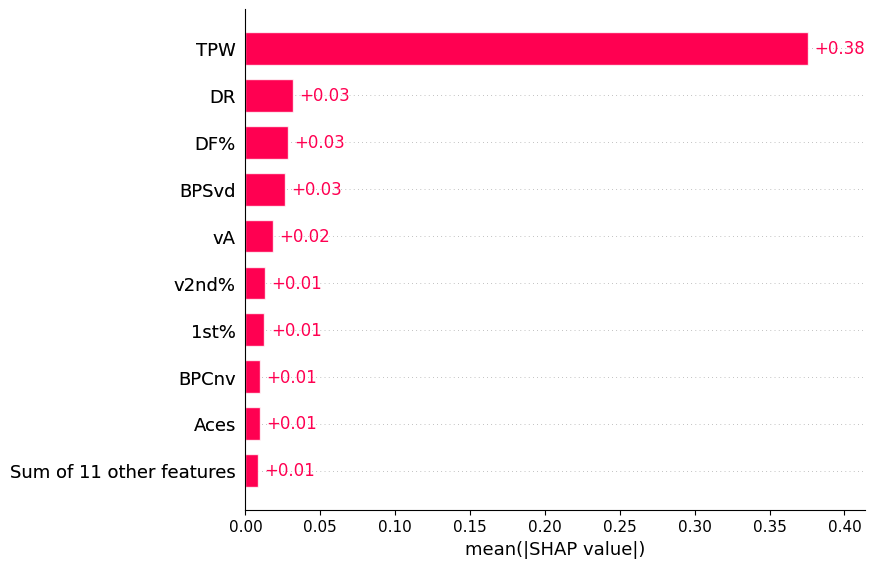

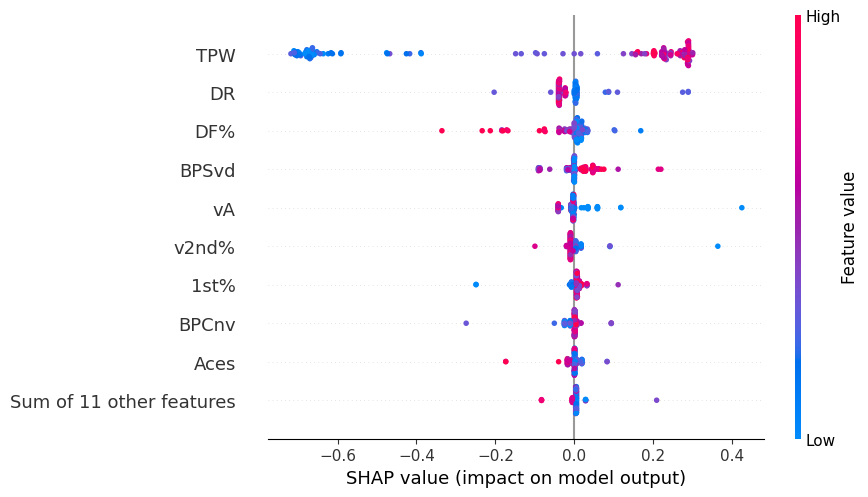

In [28]:
import shap

# Crear el explainer con el modelo y los datos de entrenamiento
explainer = shap.Explainer(dt_model, X_train)

# Calcular los valores SHAP con chequeo desactivado
shap_values = explainer(X_test, check_additivity=False)

# Extraer los valores SHAP de la clase 1 (victoria)
if len(shap_values.values.shape) == 3:
    shap_values_class1 = shap.Explanation(
        values=shap_values.values[:, :, 1],
        base_values=shap_values.base_values[:, 1],
        data=shap_values.data,
        feature_names=shap_values.feature_names
    )
else:
    shap_values_class1 = shap_values

# Visualización de importancia global
shap.plots.bar(shap_values_class1)
shap.plots.beeswarm(shap_values_class1)


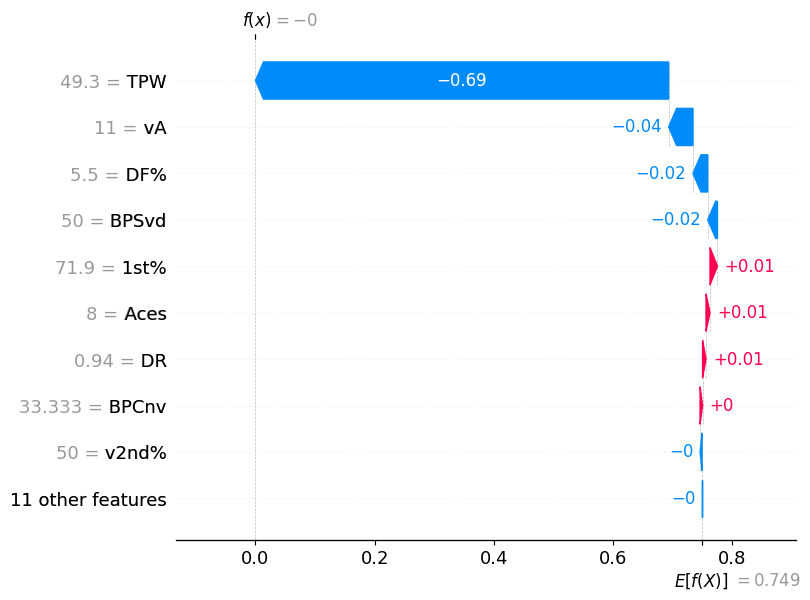

In [29]:
# Mostrar el análisis detallado para un partido (por ejemplo, el primero)
i = 0
shap.plots.waterfall(shap_values_class1[i])


In [17]:

# División entrenamiento/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar modelo Random Forest
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)

# Evaluación del modelo
rf_y_pred = rf_model.predict(X_test)
rf_report = classification_report(y_test, rf_y_pred)
print("=== Evaluación Random Forest ===")
print(rf_report)

# Importancia de variables
rf_importances = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)
print("\n=== Importancia de Variables ===")
print(rf_importances)

=== Evaluación Random Forest ===
              precision    recall  f1-score   support

           0       0.90      0.90      0.90        52
           1       0.95      0.95      0.95        95

    accuracy                           0.93       147
   macro avg       0.93      0.93      0.93       147
weighted avg       0.93      0.93      0.93       147


=== Importancia de Variables ===
TPW      0.372871
DR       0.236047
1st%     0.062438
BPCnv    0.050609
RPW      0.046315
2nd%     0.040244
v1st%    0.035247
BPSvd    0.026323
v2nd%    0.020402
A%       0.018616
DF%      0.012811
TP       0.011407
SP       0.010426
2SP      0.009216
vA       0.008649
vA%      0.008244
DFs      0.007912
Aces     0.007904
1stIn    0.007675
1SP      0.006641
dtype: float64


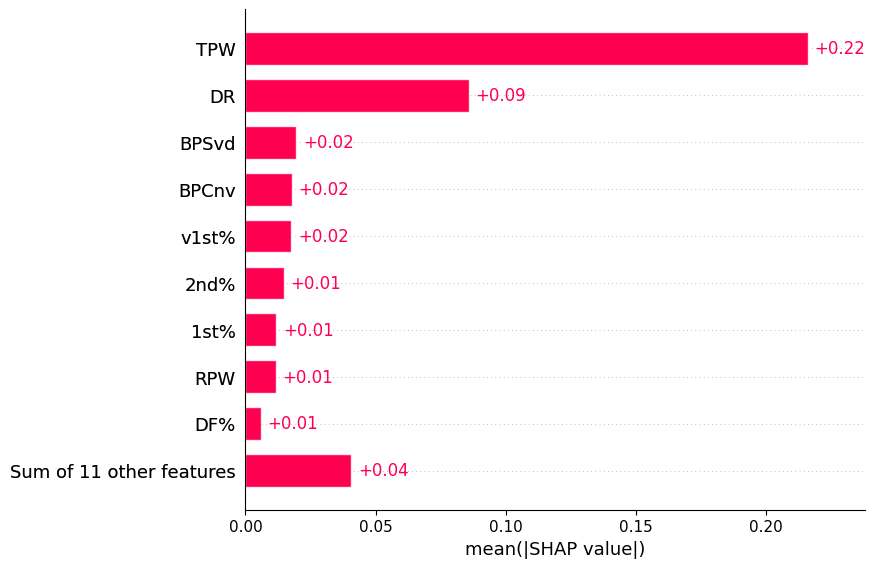

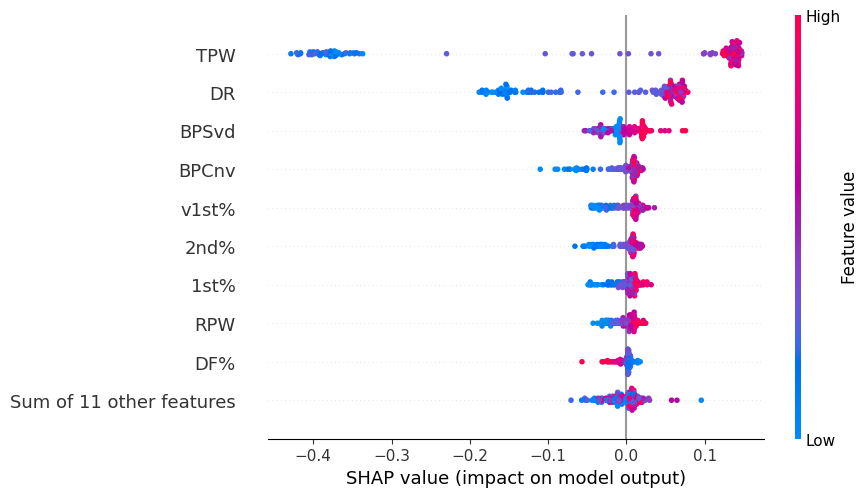

In [24]:
# 1. Crear el explainer con el modelo y X_train
explainer = shap.Explainer(rf_model, X_train)

# 2. Calcular valores SHAP (chequeo desactivado por estabilidad numérica)
shap_values = explainer(X_test, check_additivity=False)

# 3. Extraer valores SHAP de la clase 1 (victoria)
# Esto aplica solo si el output es multi-dimensional
if len(shap_values.values.shape) == 3:
    shap_values_class1 = shap.Explanation(
        values=shap_values.values[:, :, 1],
        base_values=shap_values.base_values[:, 1],
        data=shap_values.data,
        feature_names=shap_values.feature_names
    )
else:
    shap_values_class1 = shap_values  # fallback si es 2D

# 4. Visualización
shap.plots.bar(shap_values_class1)
shap.plots.beeswarm(shap_values_class1)

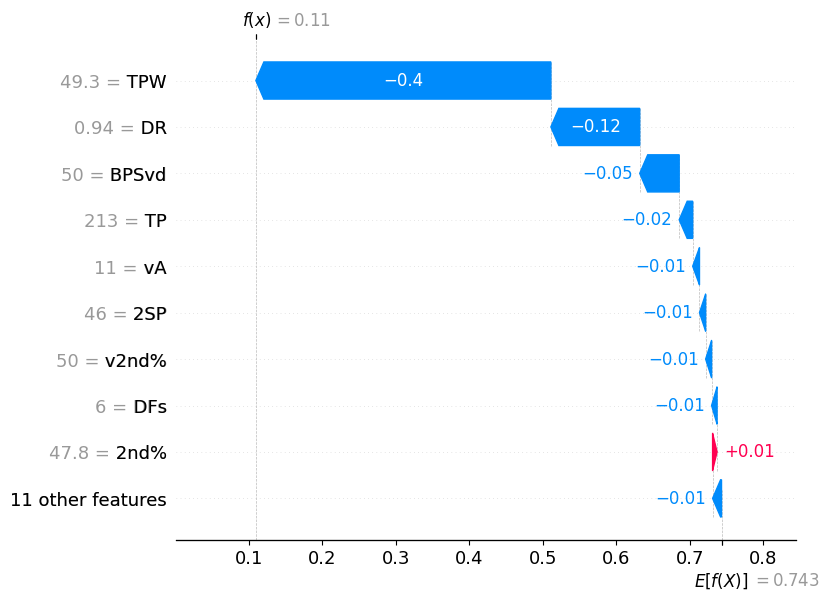

In [26]:
# Seleccionar índice del partido que quieres analizar (por ejemplo, el primero)
i = 0

# Mostrar gráfico waterfall para esa observación
shap.plots.waterfall(shap_values_class1[i])


In [ ]:

# Asumiendo que ya has entrenado el modelo con:
# rf_model = RandomForestClassifier(...).fit(X_train, y_train)

# Calcular la importancia por permutación en el conjunto de test
result = permutation_importance(
    rf_model,      # tu modelo entrenado
    X_test,        # conjunto de datos de test
    y_test,        # etiquetas verdaderas
    n_repeats=10,  # número de permutaciones (más alto = más preciso)
    random_state=42,
    scoring='accuracy'  # puedes cambiar a 'f1', 'recall', etc.
)

# Crear DataFrame ordenado
perm_importance_df = pd.DataFrame({
    'Variable': X_test.columns,
    'Importancia media': result.importances_mean,
    'Desviación estándar': result.importances_std
}).sort_values(by='Importancia media', ascending=False)

# Mostrar resultados
print("=== Importancia de Variables por Permutación ===")
print(perm_importance_df)


=== Importancia de Variables por Permutación ===
   Variable  Importancia media  Desviación estándar
7       TPW           0.309524             0.021991
6     BPSvd           0.003401             0.003401
10    v1st%           0.003401             0.003401
0        DR           0.001361             0.008497
3     1stIn           0.001361             0.002721
2       DF%           0.000680             0.002041
12    BPCnv           0.000680             0.002041
4      1st%           0.000680             0.002041
1        A%           0.000000             0.000000
5      2nd%           0.000000             0.000000
9       vA%           0.000000             0.000000
8       RPW           0.000000             0.000000
11    v2nd%           0.000000             0.000000
13       TP           0.000000             0.000000
14     Aces           0.000000             0.000000
15      DFs           0.000000             0.000000
16       SP           0.000000             0.000000
17      1SP    

Importancia media
Es la media de la caída del rendimiento (accuracy) del modelo cuando se desordena esa variable en el test set.

Cuanto más alta es, más daño hace al modelo quitar esa variable → más importante es.

Ejemplos:
TPW = 0.309524:
➤ Si se desordena esta variable, la precisión del modelo baja un 31%.
➤ Es, con diferencia, la más crítica para predecir si gana o pierde.

BPSvd = 0.003401:
➤ Su efecto es leve: baja la precisión solo 0.34%.

A%, DFs, SP, etc. = 0.0:
➤ El modelo no depende en absoluto de esas variables.

Desviación estándar
Mide la variabilidad del impacto al repetir la permutación 10 veces.

Si una variable tiene un valor alto aquí, el impacto de su permutación no es consistente (depende del orden aleatorio).

Ejemplo:

TPW:
➤ Media = 0.309
➤ Std = 0.021 → impacto bastante estable. afecta siempre lo mismo

DR:
➤ Media = 0.0013
➤ Std = 0.0085 → muy variable, posiblemente irrelevante.
-------------------
Alta importancia + baja desviación → variable relevante y confiable

Baja importancia + alta desviación → variable irrelevante o inestable

Importancia ≈ 0 y desviación ≈ 0 → variable sin ningún valor predictivo para el modelo

=== Comparación de Importancia de Variables ===
       Decision Tree  Random Forest
TPW         0.888660       0.372871
DR          0.025628       0.236047
1st%        0.007510       0.062438
BPCnv       0.009589       0.050609
RPW         0.000000       0.046315
2nd%        0.000000       0.040244
v1st%       0.000000       0.035247
DF%         0.020998       0.012811
BPSvd       0.005715       0.026323
v2nd%       0.006974       0.020402
A%          0.000000       0.018616
2SP         0.008028       0.009216
Aces        0.007613       0.007904
vA          0.006674       0.008649
1stIn       0.006102       0.007675
1SP         0.006509       0.006641
TP          0.000000       0.011407
SP          0.000000       0.010426
vA%         0.000000       0.008244
DFs         0.000000       0.007912


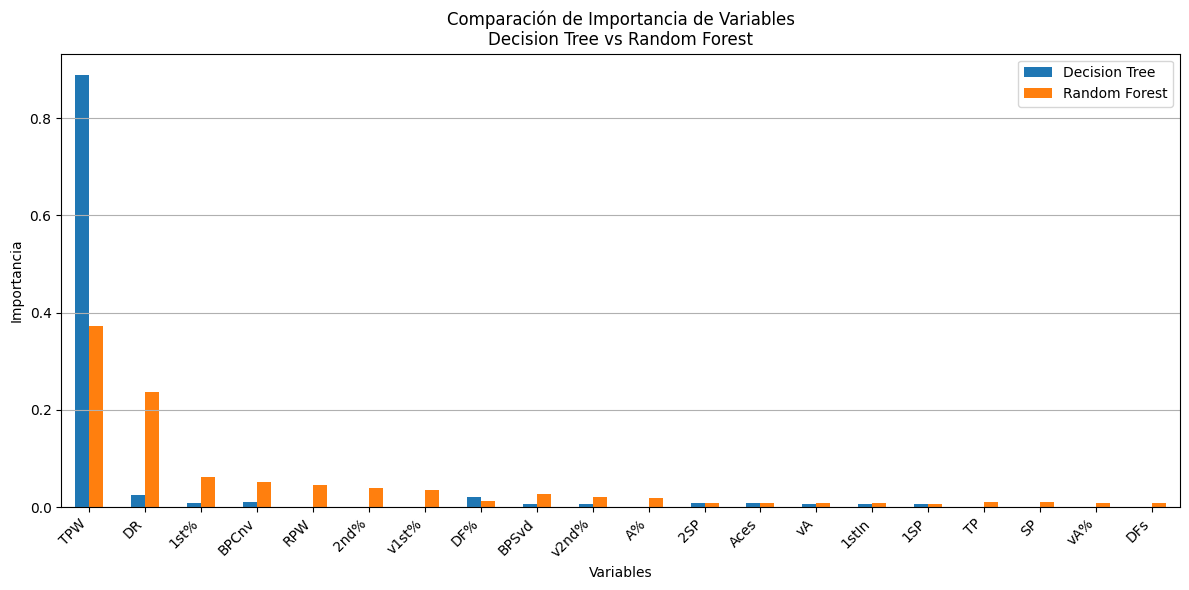

In [28]:
# Comparar importancias
comparison_df = pd.DataFrame({
    "Decision Tree": dt_model.feature_importances_,
    "Random Forest": rf_model.feature_importances_
}, index=X.columns)

# Ordenar por importancia media para visualización clara
comparison_df["Promedio"] = comparison_df.mean(axis=1)
comparison_df = comparison_df.sort_values(by="Promedio", ascending=False).drop(columns="Promedio")

# Mostrar como tabla
print("=== Comparación de Importancia de Variables ===")
print(comparison_df)

# Mostrar gráfico comparativo
comparison_df.plot(kind="bar", figsize=(12, 6))
plt.title("Comparación de Importancia de Variables\nDecision Tree vs Random Forest")
plt.ylabel("Importancia")
plt.xlabel("Variables")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.grid(axis="y")
plt.legend(loc="upper right")
plt.show()

c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:10:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


=== Clasification Report ===
              precision    recall  f1-score   support

           0       0.90      0.90      0.90        52
           1       0.95      0.95      0.95        95

    accuracy                           0.93       147
   macro avg       0.93      0.93      0.93       147
weighted avg       0.93      0.93      0.93       147


=== Importancia de Variables ===
TPW      0.540928
DR       0.102712
1SP      0.038326
v2nd%    0.030963
DFs      0.026848
RPW      0.026224
2SP      0.025375
SP       0.023248
BPCnv    0.022062
v1st%    0.020031
Aces     0.019203
1st%     0.018516
vA%      0.017152
BPSvd    0.016166
1stIn    0.014892
DF%      0.013474
vA       0.012871
2nd%     0.012417
TP       0.011935
A%       0.006656
dtype: float32


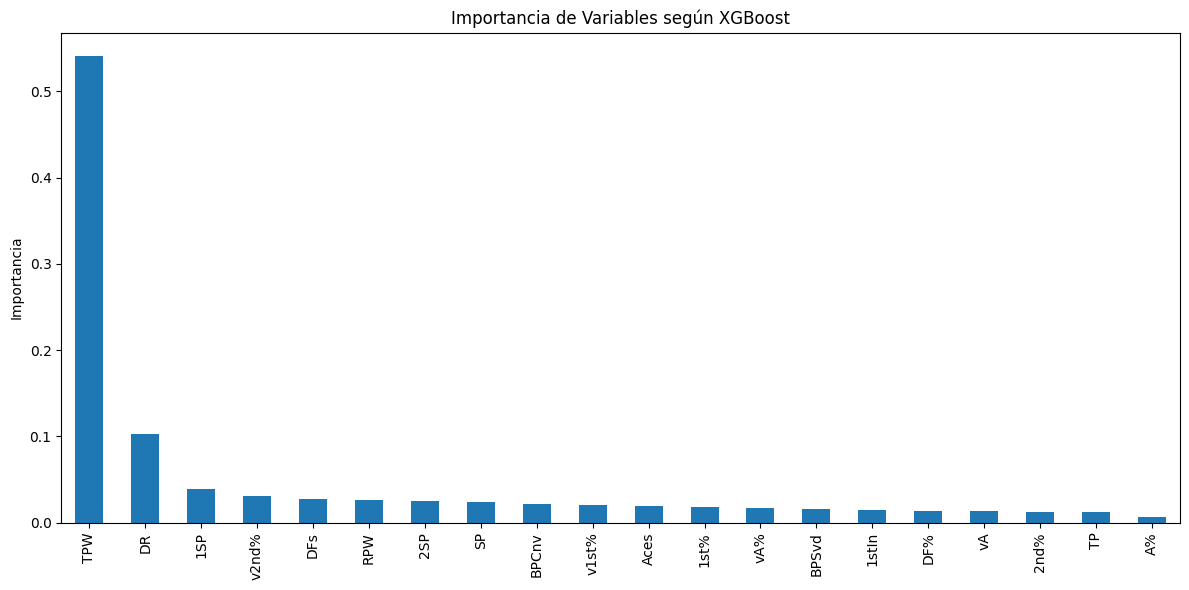

In [6]:
import xgboost as xgb


# División train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# === 2. Entrenar modelo XGBoost ===
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

xgb_model.fit(X_train, y_train)

# === 3. Evaluación del modelo ===
y_pred = xgb_model.predict(X_test)
print("=== Clasification Report ===")
print(classification_report(y_test, y_pred))

# === 4. Importancia de variables ===
importances = pd.Series(xgb_model.feature_importances_, index=X.columns).sort_values(ascending=False)

print("\n=== Importancia de Variables ===")
print(importances)

# Opcional: gráfico de barras
importances.plot(kind="bar", figsize=(12, 6), title="Importancia de Variables según XGBoost")
plt.ylabel("Importancia")
plt.tight_layout()
plt.show()

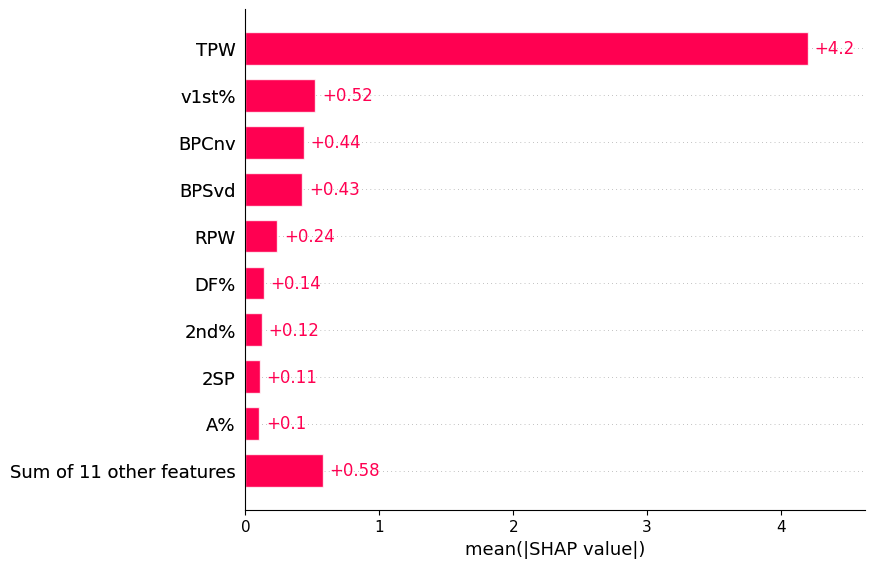

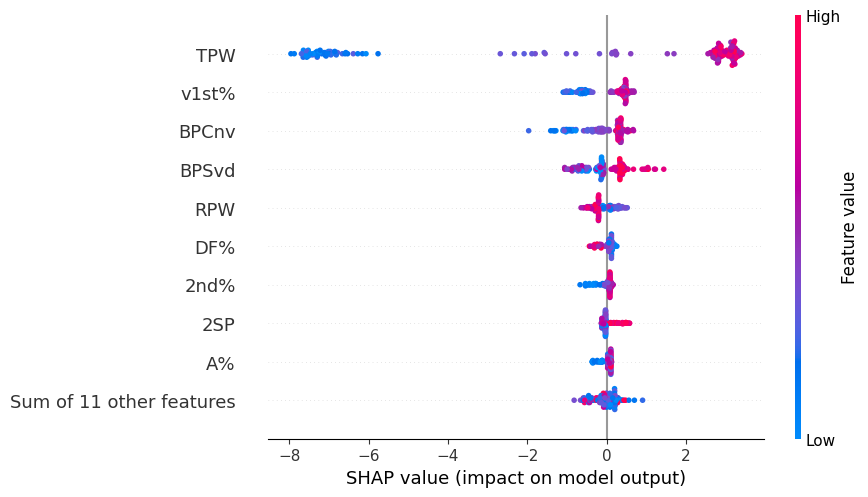

In [ ]:

# === 1. Crear el explainer para XGBoost ===
explainer = shap.Explainer(xgb_model, X_train)

# === 2. Calcular valores SHAP para el conjunto de test ===
shap_values = explainer(X_test)

# === 3. Visualización de importancia global ===
# Barra: qué variables son más influyentes en promedio
shap.plots.bar(shap_values)

# Beeswarm: cómo influye cada variable y en qué dirección
shap.plots.beeswarm(shap_values)


¿Qué muestra?
Cada punto es un partido individual.

Eje X: valor SHAP (impacto que tiene esa variable en la predicción para ese partido).

Color: valor de la variable (rojo = alto, azul = bajo).

¿Cómo interpretarlo?
Ejemplo: TPW
Puntos rojos a la derecha (SHAP > 0): partidos con TPW alto empujan la predicción hacia victoria.

Puntos azules a la izquierda (SHAP < 0): partidos con TPW bajo empujan hacia derrota.

✅ Así ves no solo qué variable importa, sino cómo y en qué dirección influye.

Otro ejemplo: BPCnv
Si el valor es alto (rojo) → tiende a contribuir positivamente al resultado.

Si es bajo (azul) → tiene un efecto negativo (predice derrota).

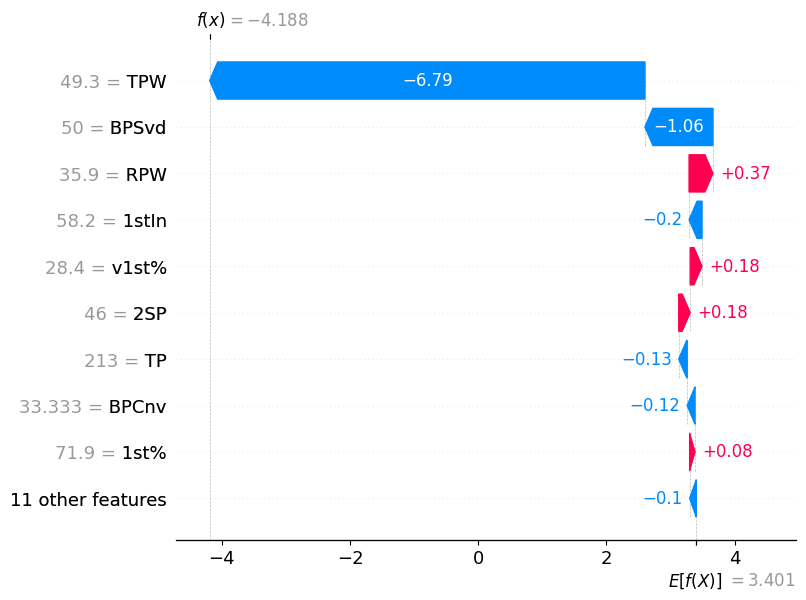

In [8]:
# === 4. Explicación individual ===
shap.plots.waterfall(shap_values[0])  # Partido 0 del test


f(x) = -4.188
Es la salida del modelo para este partido específico antes de aplicar la función sigmoide (XGBoost trabaja en log-odds).

→ Una predicción negativa implica alta probabilidad de derrota.

E[f(X)] = 3.401
Es el valor base (esperanza matemática): la predicción promedio del modelo si no sabe nada del partido (como el sesgo general del modelo).

Ejemplo: TPW = 49.3
El modelo ha visto que un TPW tan bajo suele estar muy asociado a derrotas.

Por eso le resta fuertemente (-6.79) a la predicción.

🔴 Ejemplo: RPW = 35.9
Un RPW decente aporta algo positivo → suma 0.37.

🎯 ¿Qué me dice el gráfico?
Este partido fue predicho como derrota porque:

El jugador tuvo un bajo TPW (puntos ganados).

Y no fue suficientemente compensado por otros valores.